In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/complaint-cfpb/complaints.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,4
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objs as go

import plotly.express as px

In [5]:
df = pd.read_csv('/kaggle/input/complaint-cfpb/complaints.csv')

In [6]:
df.shape

(3190837, 18)

In [7]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [8]:
#Clean column headers up
df.columns = ['DateReceived', 'Product', 'SubProduct', 'Issue','SubIssue','ConsumerComplaintNarrative', 
               'CompanyPublicResponse', 'Company', 'State', 'ZIPCode', 'Tags', 'ConsumerConsentProvided?',
               'SubmittedVia', 'DateSentToCompany', 'CompanyResponseToConsumer', 'TimelyResponse', 
               'ConsumerDisputed', 'ComplaintID']

drop_columns = ['Tags',
                'CompanyPublicResponse',
                'ConsumerConsentProvided?',
                'DateSentToCompany',
                'ComplaintID']

df = df.drop(drop_columns, 1) 

df.dtypes

DateReceived                  object
Product                       object
SubProduct                    object
Issue                         object
SubIssue                      object
ConsumerComplaintNarrative    object
Company                       object
State                         object
ZIPCode                       object
SubmittedVia                  object
CompanyResponseToConsumer     object
TimelyResponse                object
ConsumerDisputed              object
dtype: object

In [10]:
replacements = {'No': 0,
               'Yes': 1,
               'Untimely response' : 0,
               'Closed without relief': 0,
               'Closed' : 0,
               'Closed with explanation': 1,
               'Closed with non-monetary relief' : 1,
               'In progress' : np.nan,
               'Closed with relief': 1,
               'Closed with monetary relief' : 1}

df.replace(replacements, inplace = True)

In [12]:
total_of_complaints = df.shape[0]
total_of_closed_with_relief = (np.sum(df['CompanyResponseToConsumer'] == 1)/total_of_complaints)*100
total_of_closed_without_relief = (np.sum(df['CompanyResponseToConsumer'] == 0)/total_of_complaints)*100
print("Closed with relief:", round(total_of_closed_with_relief,2),"%")
print("Closed without relief:", round(total_of_closed_without_relief,2),"%")

Closed with relief: 96.32 %
Closed without relief: 1.41 %


In [9]:
categorical_variables = ['CompanyResponseToConsumer', 'TimelyResponse', 'ConsumerDisputed']
df[categorical_variables].apply(pd.Series.value_counts)

,CompanyResponseToConsumer,TimelyResponse,ConsumerDisputed
0.0,44876,50666,620062
1.0,3073395,3140171,148378


In [13]:
dfCCN = df[~df['ConsumerComplaintNarrative'].isnull()]
cat_variables = ['ConsumerComplaintNarrative']
dfCCN[cat_variables].shape # 331,077 instances

(1150291, 1)

**Extracting only first 400 complaints from database**

In [14]:
dfCCN_sample = dfCCN[0:400]
dfCCN_sample_trans = dfCCN[0:400]
dfCCN_sample[cat_variables].shape

(400, 1)

In [18]:
# Checking 'ConsumerComplaintNarrative' max length 
# Note :Limitation: Hugging face models (like BERT) can only proceed max length of 512, hence 'ConsumerComplaintNarrative' has been trimed to max length 512
dfCCN_sample['Complaint_Length'] = dfCCN_sample['ConsumerComplaintNarrative'].str.len()
maxClm = dfCCN_sample['Complaint_Length'].max()
maxClm

9415

In [19]:
# Index where B is longest
idx = dfCCN_sample["ConsumerComplaintNarrative"].apply(len).idxmax()
print(idx)
# Get that row
#dfCCN["ConsumerComplaintNarrative"][2778559]

3630


**Using different library for Sentiment analysis **

* Textblob
* SentimentIntensityAnalyzer from nltk

In [27]:
dfCCN_sample['polarity'] = dfCCN_sample['ConsumerComplaintNarrative'].map(lambda text: TextBlob(text).sentiment.polarity)
dfCCN_sample['review_len'] = dfCCN_sample['ConsumerComplaintNarrative'].astype(str).apply(len)
dfCCN_sample['word_count'] = dfCCN_sample['ConsumerComplaintNarrative'].apply(lambda x: len(str(x).split()))

In [32]:
#CFPB dataset
dfCCN_sample.head(2)

,DateReceived,Product,SubProduct,Issue,SubIssue,ConsumerComplaintNarrative,Company,State,ZIPCode,SubmittedVia,CompanyResponseToConsumer,TimelyResponse,ConsumerDisputed,Complaint_Length,polarity,review_len,word_count,sentiment
0,2022-12-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,still showing an account that should have been...,Experian Information Solutions Inc.,FL,33685.0,Web,1.0,1,NaN,439,0.171875,439,82,Positive
1,2022-11-07,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I discovered that some of the information on m...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10469.0,Web,1.0,1,NaN,669,-0.500000,669,117,Negative


In [28]:
#Create a function to get the polarity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

In [33]:
# Applying getAnalysis function to dfCCN_sample['polarity'] column
dfCCN_sample['sentiment'] = dfCCN_sample['polarity'].map(lambda score: getAnalysis(score))

In [30]:
dfCCN_sample['sentiment'].head(5)

0     Positive
1     Negative
2     Negative
14    Negative
24    Negative
Name: sentiment, dtype: object

sentiment
Negative    165
Neutral      40
Positive    195
dtype: int64


<AxesSubplot:>

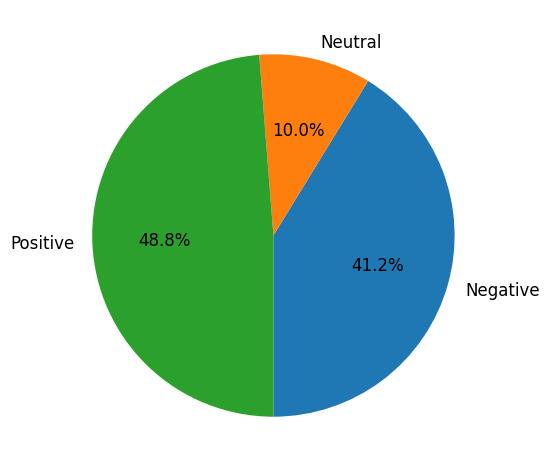

In [35]:
# Let's count the number of tweets by sentiments
sentiment_counts = dfCCN_sample.groupby(['sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [38]:
#Obtaining polarity score with TextBlob for a particular sentence
score = getPolarity("This Best Buy Citibank Credit Card is still showing a balance. This needs to be updated immediately to a ZERO BALANCE")
print(score)
getAnalysis(score)

1.0


'Positive'

In [39]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
#Sentiment analysis performed using SentimentIntensityAnalyzer from nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("This Best Buy Citibank Credit Card is still showing a balance. This needs to be updated immediately to a ZERO BALANCE")

{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.7783}

In [41]:
fig = px.histogram(dfCCN_sample, x="polarity", nbins=30,
                   title='Sentiment Polarity Distribution',
                   labels={'polarity':'polarity'}, # can specify one label per df column
                   opacity=0.8,
                   log_y=True, # represent bars with log scale
                   color_discrete_sequence=['indianred'] # color of histogram bars
                   )
fig.show()

# **Hugging Face models used for Sentiment analysis**

In [42]:
#Install dependencies
!pip install -q transformers

In [43]:
# Using pipeline class to make predictions from models available in the Hub in an easy way 

from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["This Best Buy Citibank Credit Card is still showing a balance. This needs to be updated immediately to a ZERO BALANCE"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

2023-02-06 06:49:08.475201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:49:08.476341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:49:08.476996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:49:08.479037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 0.9995643496513367}]

In [44]:
# Using a specific model for sentiment analysis
specific_model1 = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model1(data)

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'NEG', 'score': 0.8879547715187073}]

In [45]:
# Using a specific model for sentiment analysis
specific_model2 = pipeline('sentiment-analysis', model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
specific_model3 = pipeline('sentiment-analysis', model="ahmedrachid/FinancialBERT-Sentiment-Analysis")
specific_model2(data)


Downloading:   0%|          | 0.00/933 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/789 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'neutral', 'score': 0.9987462759017944}]

In [46]:
#type(dfCCN["ConsumerComplaintNarrative"])
dfCCN_sample["ConsumerComplaintNarrative_list"] = dfCCN_sample["ConsumerComplaintNarrative"].values.tolist()

dfCCN_sample.shape

(400, 19)

In [49]:
from transformers import BertTokenizer, BertModel
from transformers import pipeline

In [50]:
model_name="finiteautomata/bertweet-base-sentiment-analysis"
classifier = pipeline('sentiment-analysis', model=model_name)

In [51]:
#Performing Sentiment analysis for long text 
long_text = dfCCN_sample["ConsumerComplaintNarrative"][idx]
#without truncation, index out of range error is coming
score = classifier(long_text,truncation=True)
score

[{'label': 'NEG', 'score': 0.8654312491416931}]

**Performing sentiment analysis for 'ConsumerComplaintNarrative' column of CFPB dataset while truncating the text length to bert based analysis**

In [52]:
dfCCN_sample_trans['score'] = dfCCN_sample_trans['ConsumerComplaintNarrative'].map(lambda text: classifier(text,truncation=True))

In [53]:
dfCCN_sample_trans['score'][0][0]['score']

0.9469210505485535

In [54]:
dfCCN_sample_trans['sentiment'] = dfCCN_sample_trans['score'].str[0].str['label']
dfCCN_sample_trans['polarity'] = dfCCN_sample_trans['score'].str[0].str['score']
#dfCCN_sample_trans['sentiment'].head(5)
#dfCCN_sample_trans['polarity'].head(2)


sentiment
NEG    304
NEU     95
POS      1
dtype: int64


<AxesSubplot:>

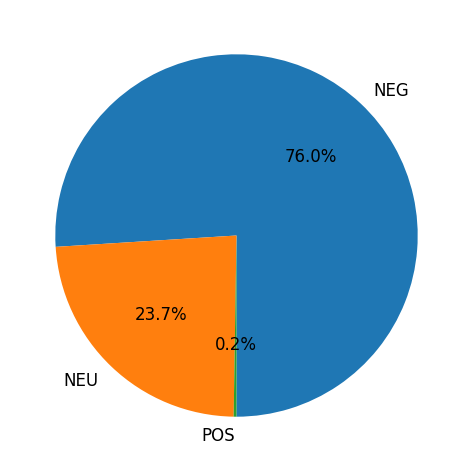

In [55]:
# Let's count the number of tweets by sentiments
sentiment_counts = dfCCN_sample_trans.groupby(['sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [56]:
dfCCN_sample_trans.head(2)

,DateReceived,Product,SubProduct,Issue,SubIssue,ConsumerComplaintNarrative,Company,State,ZIPCode,SubmittedVia,CompanyResponseToConsumer,TimelyResponse,ConsumerDisputed,score,sentiment,polarity
0,2022-12-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,still showing an account that should have been...,Experian Information Solutions Inc.,FL,33685.0,Web,1.0,1,NaN,"[{'label': 'NEG', 'score': 0.9469210505485535}]",NEG,0.946921
1,2022-11-07,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I discovered that some of the information on m...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10469.0,Web,1.0,1,NaN,"[{'label': 'NEG', 'score': 0.5073055028915405}]",NEG,0.507306


In [57]:
fig = px.histogram(dfCCN_sample_trans, x="sentiment", nbins=30,
                   title='Sentiment Polarity Distribution',
                   labels={'polarity':'polarity'}, # can specify one label per df column
                   opacity=0.8,
                   log_y=True, # represent bars with log scale
                   color_discrete_sequence=['indianred'] # color of histogram bars
                   )
fig.show()